In [1]:
from matplotlib import pyplot
import matplotlib
import pandas
from CO2_data_collector import CO2DataCollector
from fbprophet import Prophet

Importing plotly failed. Interactive plots will not work.


# Collect the data
In this section we show how to collect the emissions data for a given time period

In [3]:
collector = CO2DataCollector()

In [4]:
# Collects the data between two boundaries dates
collector.collect_data('2017-01-01', '2020-01-01')

In [5]:
# Generates a CSV file with the collected data
collector.generate_csv('Emissions_2018-2020.csv')

# Data Cleaning
In this section we will perform some data cleaning since there are some corrupted data
that needs to be cleaned to convert the Fecha's column from string to a datetime object

In [6]:
dataset = pandas.read_csv('Emissions_2018-2020.csv')

In [7]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157680 entries, 0 to 157679
Data columns (total 3 columns):
Unnamed: 0    157680 non-null int64
Fecha         157680 non-null object
Emisiones     157680 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 3.6+ MB


Is there a problem with the data, on certain dates on the interval from 02 to 03, where there are corrupted hours like the following ones:
- 2019-10-27 2A:00
- 2019-10-27 2A:10
- 2019-10-27 2A:20
- 2019-10-27 2A:30
- 2019-10-27 2A:40
- 2019-10-27 2A:50
- 2019-10-27 2B:00
- 2019-10-27 2B:10
- 2019-10-27 2B:20
- 2019-10-27 2B:30
- 2019-10-27 2B:40
- 2019-10-27 2B:50

**Solution:**
- Drop rows which contain the letter 'B' in the Fecha's column
- In the rows where the date contains the characters 2A, replace these with 02

In [8]:
# Replace dates with 2A by 02
dataset['Fecha'] = dataset['Fecha'].str.replace('2A', '02')
# Use the NOT simbol (~) to return the dataset without these rows
dataset = dataset[~dataset.Fecha.str.contains("2B")]

In [9]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 157662 entries, 0 to 157679
Data columns (total 3 columns):
Unnamed: 0    157662 non-null int64
Fecha         157662 non-null object
Emisiones     157662 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 4.8+ MB


The number of instances now is 52554, so 6 rows have been removed

In [10]:
# Removes the index which is the 'Unnamed: 0' column
dataset = dataset.reset_index(drop=True)

In [11]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 157662 entries, 0 to 157679
Data columns (total 3 columns):
Unnamed: 0    157662 non-null int64
Fecha         157662 non-null datetime64[ns]
Emisiones     157662 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 4.8 MB


Unnamed: 0 column has been removed

In [20]:
# Creates a new CSV with no data errors
dataset.to_csv("2017-2020_Emissions_Clean.csv", index=False)

# Data Analysis

In [25]:
# Read the csv and sets the 'Fecha' at 0 as index
dataset = pandas.read_csv('2017-2020_Emissions_Clean.csv')

In order to plot the data we need to perform the following tasks:
- Convert 'Fecha' column to datetime object
- Set 'Fecha' column as the new index

In [26]:
# Converts 'Fecha' to datetime object
dataset['Fecha'] = pandas.to_datetime(dataset['Fecha'])
# Sets the 'Fecha' column as index
dataset = dataset.set_index('Fecha')

In [27]:
dataset.head()

,Emisiones
Fecha,
2016-12-31 21:00:00,9659.81
2016-12-31 21:10:00,9627.94
2016-12-31 22:30:00,9407.57
2016-12-31 21:20:00,9562.48
2016-12-31 21:30:00,9545.36


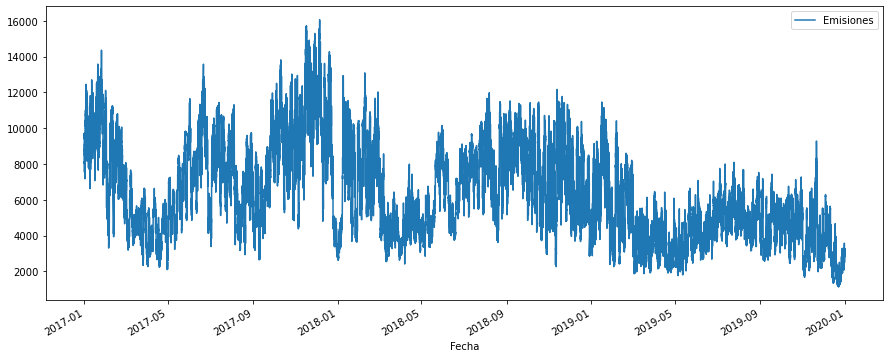

In [10]:
dataset.plot(figsize=(15, 6))
pyplot.show()

The seasonality must be deep analysed because the emissions could be affected by the laws of Spain, the government may have created some laws to increase
the renovable energies, so due to that the data could be different in years

# Prophet model

In [17]:
prophet = Prophet()

In [21]:
dataset = dataset.rename(columns={"Fecha": "ds", "Emisiones": "y"})

In [22]:
dataset.head()

,ds,y
Unnamed: 0,,
0,2016-12-31 21:00:00,9659.81
1,2016-12-31 21:10:00,9627.94
2,2016-12-31 22:30:00,9407.57
3,2016-12-31 21:20:00,9562.48
4,2016-12-31 21:30:00,9545.36


In [ ]:
prophet.fit(dataset)

In [ ]:
future = prophet.make_future_dataframe(periods=365)
future.tail()

In [ ]:
forecast = prophet.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

In [ ]:
fig1 = prophet.plot(forecast)